## About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas.   
Customer first apply for home loan after that company validates the customer eligibility for loan.


## Problem Statement

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
# Model have being trained on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read files

We have two csv file, a train set and a submission set.

In [0]:
df_train = pd.read_csv('drive/My Drive/Tech Mahindra/Loan Train.csv')
df_test = pd.read_csv('drive/My Drive/Tech Mahindra/Loan Test.csv')
df_test_copy = df_test.copy()

In [5]:
df_train.head(n = 10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


## Exploratory Data Analysis

### Class imbalanced

Loan_Status has 70% positive and 30% negative cases. Although this are imbalanced, they cannot be termed as highly imbalanced class.  

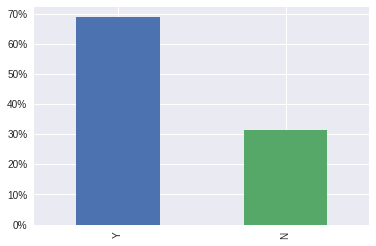

In [6]:
df_train['Loan_Status'].value_counts(normalize=True).plot.bar().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#sns.barplot(df_train['Loan_Status'])

### Outlier

From the below plots, we notice that Applicant Income and Co-applicant Income has some outliers.   
In few application, despite having high incomes their loan were rejected.

We can either remove them considering mistakes or transform them to remove their effect on statistics.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0.5, 0, 'Combined Income')]

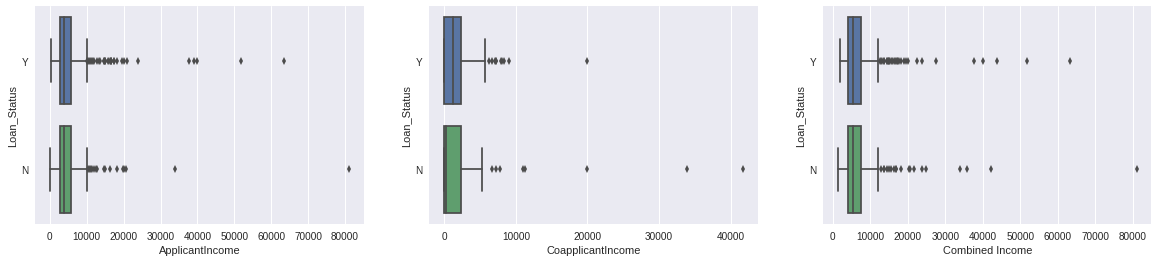

In [7]:
plt.figure(figsize=(20, 4))

plt.subplot(1,3,1)
sns.boxplot(x = df_train["ApplicantIncome"], y = df_train["Loan_Status"])
plt.subplot(1,3,2)
sns.boxplot(x = df_train["CoapplicantIncome"], y = df_train["Loan_Status"])
plt.subplot(1,3,3)
sns.boxplot(x = (df_train["ApplicantIncome"] + df_train["CoapplicantIncome"]), y = df_train["Loan_Status"]).set(xlabel='Combined Income')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


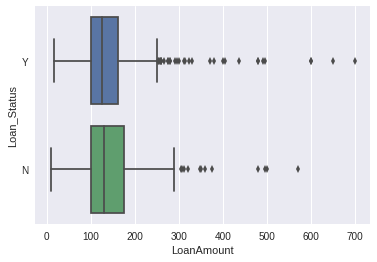

In [8]:
sns.boxplot(x = df_train["LoanAmount"], y = df_train["Loan_Status"])

#sns.heatmap(x = df_train["Property_Area"], y = df_train["Loan_Status"], data = df_train)


### Feature Engineering

Income - The applicant and co-applicant are two different people. But since the loan is issued as a combined entity. Both these varaibles can be summed up.

EMI - The installment paid by applicant. This may help us to detect cases with high EMI but low Income. 
We assume interest is 8.65% for male and 8.6% for female.

In [0]:
# Loan Amount * Interest rate * (1 + int rate) ^ Period/(( 1 + r)) ^ Period - 1
#P*r*(1 + r)**n/((1 + r)**n - 1)
mr = 8.65/(12*100)
fr = 8.6/(12*100)

#mr = df_train["LoanAmount"] * 1000 * r * (1 + mr) ** df_train["Loan_Amount_Term"]/(( 1 + mr)) ** df_train["Loan_Amount_Term"] -1
#fmr = df_train["LoanAmount"] * 1000 * r * (1 + fr) ** df_train["Loan_Amount_Term"]/(( 1 + fr)) ** df_train["Loan_Amount_Term"] -1

df_train['EMI'] = np.where(df_train['Gender']=='Male', df_train["LoanAmount"] * 1000 * mr * (1 + mr) ** df_train["Loan_Amount_Term"]/(( 1 + mr)) ** df_train["Loan_Amount_Term"] -1, df_train["LoanAmount"] * 1000 * fr * (1 + fr) ** df_train["Loan_Amount_Term"]/(( 1 + fr)) ** df_train["Loan_Amount_Term"] -1)
df_test['EMI'] = np.where(df_test['Gender']=='Male', df_test["LoanAmount"] * 1000 * mr * (1 + mr) ** df_test["Loan_Amount_Term"]/(( 1 + mr)) ** df_test["Loan_Amount_Term"] -1, df_test["LoanAmount"] * 1000 * fr * (1 + fr) ** df_test["Loan_Amount_Term"]/(( 1 + fr)) ** df_test["Loan_Amount_Term"] -1)
#df_train["EMI"] = (df_train["LoanAmount"] * 1000) * r * (1 + r) ** df_train["Loan_Amount_Term"]/(( 1 + r)) ** df_train["Loan_Amount_Term"] -1
#df_test["EMI"] = (df_test["LoanAmount"] * 1000) * r * (1 + r) ** df_test["Loan_Amount_Term"]/(( 1 + r)) ** df_test["Loan_Amount_Term"] -1

df_train["Income"] = df_train["ApplicantIncome"] + df_train["CoapplicantIncome"]
df_test["Income"] = df_test["ApplicantIncome"] + df_test["CoapplicantIncome"]
df_train.drop(["CoapplicantIncome", "ApplicantIncome"], axis = 1, inplace = True)
df_test.drop(["CoapplicantIncome", "ApplicantIncome"], axis = 1, inplace = True)

Dependent column has 3+, because of which it is termed as a string variable. Lets convert all 3+ values to 4. In a real world, we cap number of childern to four.

In [0]:
df_train["Dependents"] = df_train["Dependents"].replace("3+",  4)
df_train["Dependents"] = pd.to_numeric(df_train["Dependents"])

df_test["Dependents"] = df_test["Dependents"].replace("3+",  4)
df_test["Dependents"] = pd.to_numeric(df_test["Dependents"])

### Missing Value

Now that we have our new features as well, lets impute missing values.  
Categorical variables with missing data -  Gender, Married, Dependents, Self_employed and Credit_history  
Numerical variable with missing data - LoanAmount and Loan_Amount_Term  

Credit_History (8.14%) - is the maximum missing variable in the dataset

In [11]:
df_train.isnull().sum() * 100 / len(df_train)

Loan_ID             0.000000
Gender              2.117264
Married             0.488599
Dependents          2.442997
Education           0.000000
Self_Employed       5.211726
LoanAmount          3.583062
Loan_Amount_Term    2.280130
Credit_History      8.143322
Property_Area       0.000000
Loan_Status         0.000000
EMI                 5.863192
Income              0.000000
dtype: float64

Impute missing value  
For categorical data we will impute 'Mode' - the maximum occurred category.  
For numerical we simly will use mean.
Note: Since objective is prediction and not interpretation, we plan to use decision trees for modelling; they have no assumption.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdba8b66cf8>]],
      dtype=object)

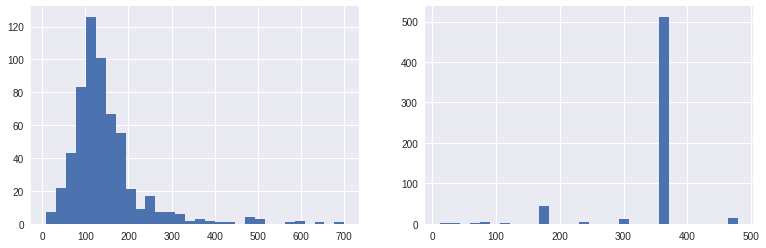

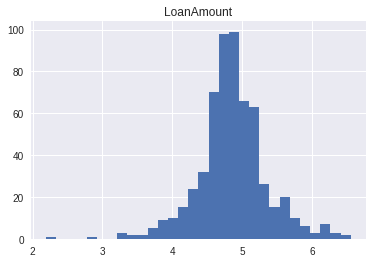

In [12]:
#https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
df_train["LoanAmount"].hist(bins = 30)
plt.subplot(1, 3, 2)
df_train["Loan_Amount_Term"].hist(bins = 30)
#plt.subplot(1, 3, 3)
pd.DataFrame(np.log(df_train["LoanAmount"])).hist(bins = 30)

From above plots we confirm that Loan Amount variable is skwed and hence need log transformation for a normal distribution.  

Although Loan Amount Term is a numerical variable, a lot of people prefer 360 (30 year) loan period.  
As such, instead of mean/median, we will use mode imputation.

In [0]:
# We need this information to be imputed in test set and submission set as well.
GenderMode = df_train['Gender'].mode()[0]
MarriedMode = df_train['Married'].mode()[0]
DependentsMode = df_train['Dependents'].mode()[0]
SelfEmployedMode = df_train['Self_Employed'].mode()[0]
CreditHistoryMode = df_train['Credit_History'].mode()[0]
LoanTermMode = df_train['Loan_Amount_Term'].mode()[0]
LoanAmountMean = df_train['LoanAmount'].mean()
EMIMean = df_train['EMI'].mean()

In [0]:
df_train['Gender'].fillna(GenderMode, inplace=True)
df_train['Married'].fillna(MarriedMode, inplace=True)
df_train['Dependents'].fillna(DependentsMode, inplace=True)
df_train['Self_Employed'].fillna(SelfEmployedMode, inplace=True)
df_train['Credit_History'].fillna(CreditHistoryMode, inplace=True)
df_train['Loan_Amount_Term'].fillna(LoanTermMode, inplace=True)

df_train['LoanAmount'].fillna(LoanAmountMean, inplace=True)
df_train['EMI'].fillna(EMIMean, inplace=True)

# Test set
df_test['Gender'].fillna(GenderMode, inplace=True)
df_test['Married'].fillna(MarriedMode, inplace=True)
df_test['Dependents'].fillna(DependentsMode, inplace=True)
df_test['Self_Employed'].fillna(SelfEmployedMode, inplace=True)
df_test['Credit_History'].fillna(CreditHistoryMode, inplace=True)
df_test['Loan_Amount_Term'].fillna(LoanTermMode, inplace=True)

df_test['LoanAmount'].fillna(LoanAmountMean, inplace=True)
df_test['EMI'].fillna(EMIMean, inplace=True)

In [0]:
# This feature engineering is here, since it is calculated after imputing missing values
df_train["incomeToLoan"] = df_train["Income"]/df_train["LoanAmount"]
df_test["incomeToLoan"] = df_test["Income"]/df_test["LoanAmount"]

## Manage Outlier
We remember that Applicant Income and Co-applicant income had a few outliers which can be either removed or transformed.

From below plots, we can confirm that upon transformation even though the outliers are not completely removed but their effects are controlled.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


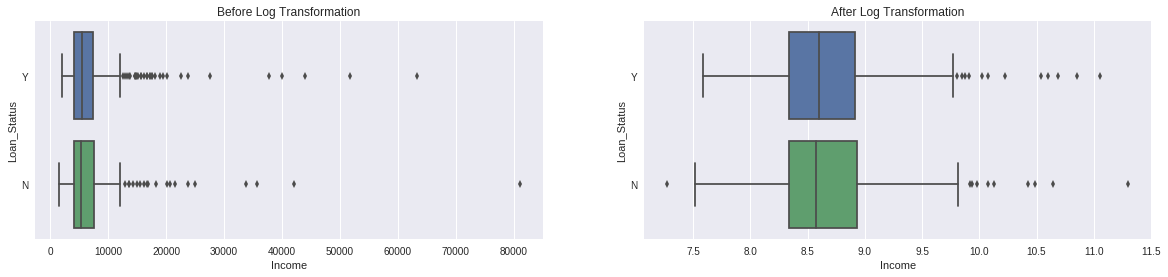

In [16]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
sns.boxplot(df_train["Income"], df_train["Loan_Status"]).set_title('Before Log Transformation')

plt.subplot(1, 2, 2)
sns.boxplot(np.log(df_train["Income"]), df_train["Loan_Status"]).set_title('After Log Transformation')

df_train["Income"] = np.log(df_train["Income"])
df_test["Income"] = np.log(df_test["Income"])
plt.show()

## Convert text to label

Scikit-learn needs all numeric variables. Hence lets convert all categories to numerical (nominal) values.

In [0]:
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Education"] = le.fit_transform(df_train["Education"])
df_train["Property_Area"] = le.fit_transform(df_train["Property_Area"])
df_train["Married"] = le.fit_transform(df_train["Married"])
df_train["Self_Employed"] = le.fit_transform(df_train["Self_Employed"])

df_test["Gender"] = le.fit_transform(df_test["Gender"])
df_test["Education"] = le.fit_transform(df_test["Education"])
df_test["Property_Area"] = le.fit_transform(df_test["Property_Area"])
df_test["Married"] = le.fit_transform(df_test["Married"])
df_test["Self_Employed"] = le.fit_transform(df_test["Self_Employed"])

In [18]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,EMI,Income,incomeToLoan
0,LP001002,1,0,0.0,0,0,146.412162,360.0,1.0,2,Y,1058.489908,8.674026,39.948867
1,LP001003,1,1,1.0,0,0,128.000000,360.0,1.0,0,N,921.666667,8.714568,47.585938
2,LP001005,1,1,0.0,0,1,66.000000,360.0,1.0,2,Y,474.750000,8.006368,45.454545
3,LP001006,1,1,0.0,1,0,120.000000,360.0,1.0,2,Y,864.000000,8.505323,41.175000
4,LP001008,1,0,0.0,0,0,141.000000,360.0,1.0,2,Y,1015.375000,8.699515,42.553191


## Split Data

In [19]:
X = df_train.drop(["Loan_ID", "Loan_Status"], axis=1)
y = df_train["Loan_Status"]

df_test = df_test.drop(["Loan_ID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .75, random_state = 42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Random Forest

In [20]:
rand_forest = RandomForestClassifier( random_state = 42 )
rand_forest.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
accuracy_score(y_test, rand_forest.predict(X_test))

0.7727272727272727

### Random Forest Hyper parameters tuning

Random Forest has a lot of tuning parameters, we tune the model for max_depth, n_estimators and  
We will use a five cross validation approach, repeated over 10 times.

In [0]:
repeatcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

In [23]:
paramgrid = {'max_depth': list(range(1, 5, 2)), 'n_estimators': list(range(100, 200, 20)), 'max_features': ['auto', 'sqrt', 'log2'], 'oob_score' :['True', 'False']}

rand_grid = GridSearchCV (rand_forest, paramgrid, cv = 3, scoring = 'accuracy' ) 

rand_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 3], 'n_estimators': [100, 120, 140, 160, 180], 'max_features': ['auto', 'sqrt', 'log2'], 'oob_score': ['True', 'False']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
#rand_model_grid_score = cross_val_score(rand_grid, X_train, y_train, scoring = "accuracy", cv = repeatcv )

In [25]:
accuracy_score(y_test, rand_grid.predict(X_test))

0.7727272727272727

In [0]:
from sklearn import metrics
rand_proba = rand_grid.predict_proba(X_test)[::,1]
randfpr, randtpr, _ = metrics.roc_curve(y_test,  rand_proba, pos_label='Y')
randauc = metrics.roc_auc_score(y_test, rand_proba)

## Gradient Boosting

In [27]:
gbModel = GradientBoostingClassifier()
gbModel.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [28]:
accuracy_score(y_test, gbModel.predict(X_test))

0.7857142857142857

### Gradient Boosting Hyperparameters tuning

In [29]:
params = {'max_depth': list(range(1, 5, 2)), 'n_estimators': list(range(1, 10, 2)), 'subsample': [0.8, 1.0], 'min_samples_split' : list(range(2, 10, 1))}

gbModel_grid = GridSearchCV(gbModel, params, cv = 3, scoring = 'accuracy') 

gbModel_grid.fit (X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 3], 'n_estimators': [1, 3, 5, 7, 9], 'subsample': [0.8, 1.0], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
#xgb_model_grid_score = cross_val_score(xgb_grid, X_train, y_train, scoring = "accuracy", cv = repeatcv )

In [31]:
accuracy_score(y_test, gbModel_grid.predict(X_test))

0.7727272727272727

In [0]:
gbModel_proba = gbModel_grid.predict_proba(X_test)[::,1]
gbmfpr, gbmtpr, _ = metrics.roc_curve(y_test,  gbModel_proba, pos_label='Y')
gbmauc = metrics.roc_auc_score(y_test, gbModel_proba)

## XGBoost

In [33]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
accuracy_score(y_test, xgb_model.predict(X_test))

0.7922077922077922

### XGBoost HyperParameter

In [35]:
params = {'max_depth': list(range(1, 5, 2)), 'n_estimators': list(range(10, 200, 20)), 'subsample': [0.8, 1.0]}

xgb_model_grid = GridSearchCV(xgb_model, params, cv = 3, scoring = 'accuracy') 

xgb_model_grid.fit (X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 3], 'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190], 'subsample': [0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
xgb_proba = xgb_model_grid.predict_proba(X_test)[::,1]
xgbfpr, xgbtpr, _ = metrics.roc_curve(y_test,  xgb_proba, pos_label='Y')
xgbauc = metrics.roc_auc_score(y_test, xgb_proba)

In [37]:
accuracy_score(y_test, xgb_model_grid.predict(X_test))

0.7857142857142857

## ROC Curves

From the below chart, we can see that Random Forest model has the higher AUC followed by XGB and least value for GBM. Overall, we choose the middle model to avoid overfitting and underfitting.




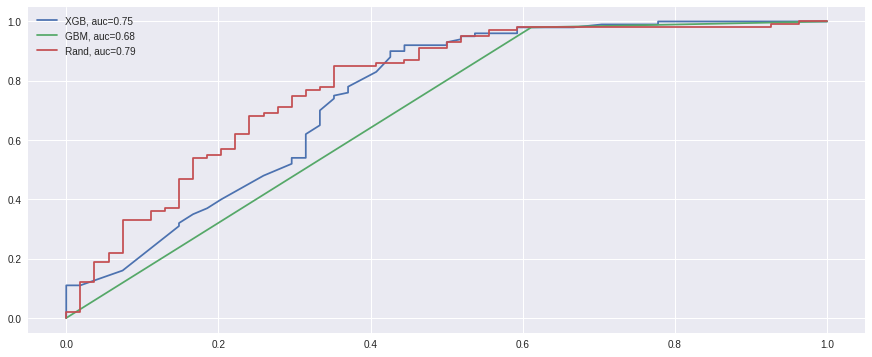

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(xgbfpr,xgbtpr,label="XGB, auc="+str(round(xgbauc, 2)))
plt.plot(gbmfpr,gbmtpr,label="GBM, auc="+str(round(gbmauc, 2)))
plt.plot(randfpr,randtpr,label="Rand, auc="+str(round(randauc, 2)))
plt.legend(loc=0)
plt.show()

## Final Model

As such the final model we select is **'XGBoost'**

In [0]:
pd.DataFrame({"Loan_ID":(df_test_copy.Loan_ID), "Loan_Status":xgb_model_grid.predict(df_test)}).reset_index(drop = True).to_csv("submitTM.csv")

## Deploymnet

The model can be deployed using python flask, django or other web development tools.   
An HTTP API can be build to use it with other services.